### Install liten
Must install latest liten before running the commands
Install from released package from pypi
```bash
$ pip install -i https://test.pypi.org/simple/ liten
```
Read local setup.py and install liten
```bash
pip install /mnt/c/Users/hkver/Documents/dbai/dbaistuff/py/liten
```
Install from local wheel file
```bash
pip install /mnt/c/Users/hkver/Documents/dbai/dbaistuff/py/liten/dist/liten-0.0.1-py3-none-any.whl
```

Import arrow and liten

In [1]:
import pyarrow as pa
from pyarrow import csv

In [2]:
import liten as ten

<frozen importlib._bootstrap>:219: RuntimeWarning: compiletime version 3.6 of module 'liten._liten' does not match runtime version 3.8
<frozen importlib._bootstrap>:219: RuntimeWarning: builtins.type size changed, may indicate binary incompatibility. Expected 864 from C header, got 880 from PyObject


Name of the Tpch fact and dimension tables. Names must be unique. They are used in SQL queries.

In [3]:
fact_tables = ['lineitem']
dim_tables = ['customer','orders','supplier','nation','region']
tpch_dir = '/mnt/c/Users/hkver/Documents/dbai/tpch-kit/sf1g/'

Create a Liten cache. Cache holds tabular data, tensor, and all other metadata. Print version information. Print worker nodes available on Liten cluster.

In [4]:
tc = ten.new_cache()

In [5]:
tc.version

'0.0.1'

In [6]:
tc.info()

b'{\n"Worker Threads":6\n}\n,{\n{}\n}'

In [7]:
pa.show_versions()

pyarrow version info
--------------------
Package kind: not indicated
Arrow C++ library version: 4.0.1
Arrow C++ compiler: GNU 7.3.0
Arrow C++ compiler flags: -fvisibility-inlines-hidden -std=c++17 -fmessage-length=0 -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/hkverma/miniconda3/envs/liten/include -fdebug-prefix-map=/tmp/build/80754af9/arrow-cpp_1622562886179/work=/usr/local/src/conda/arrow-cpp-4.0.1 -fdebug-prefix-map=/home/hkverma/miniconda3/envs/liten=/usr/local/src/conda-prefix -fdiagnostics-color=always -O3 -DNDEBUG
Arrow C++ git revision: 
Arrow C++ git description: 


Read SF=1 Tpch Csv tables.  Schema is inferred from the csv files.

In [8]:
%%time
def read_tables(tables):
    arrow_tables = []
    for table_name in tables:
        tpch_table = tpch_dir+table_name+'.tbl'
        print('Reading ', tpch_table)
        pytable = pa.csv.read_csv(input_file=tpch_table, parse_options=csv_options)
        print(' Rows=', pytable.num_rows,' Cols=', pytable.num_columns)
        arrow_tables.append(pytable)
    return arrow_tables
csv_options = pa.csv.ParseOptions(delimiter='|')
pa_fact_tables = read_tables(fact_tables)
pa_dim_tables = read_tables(dim_tables)

Reading  /mnt/c/Users/hkver/Documents/dbai/tpch-kit/sf1g/lineitem.tbl
 Rows= 6001215  Cols= 16
Reading  /mnt/c/Users/hkver/Documents/dbai/tpch-kit/sf1g/customer.tbl
 Rows= 150000  Cols= 8
Reading  /mnt/c/Users/hkver/Documents/dbai/tpch-kit/sf1g/orders.tbl
 Rows= 1500000  Cols= 9
Reading  /mnt/c/Users/hkver/Documents/dbai/tpch-kit/sf1g/supplier.tbl
 Rows= 10000  Cols= 7
Reading  /mnt/c/Users/hkver/Documents/dbai/tpch-kit/sf1g/nation.tbl
 Rows= 25  Cols= 4
Reading  /mnt/c/Users/hkver/Documents/dbai/tpch-kit/sf1g/region.tbl
 Rows= 5  Cols= 3
CPU times: user 5.45 s, sys: 1.65 s, total: 7.1 s
Wall time: 3.1 s


In [9]:
pa_fact_tables

[pyarrow.Table
 L_ORDERKEY: int64
 L_PARTKEY: int64
 L_SUPPKEY: int64
 L_LINENUMBER: int64
 L_QUANTITY: int64
 L_EXTENDEDPRICE: double
 L_DISCOUNT: double
 L_TAX: double
 L_RETURNFLAG: string
 L_LINESTATUS: string
 L_SHIPDATE: date32[day]
 L_COMMITDATE: date32[day]
 L_RECEIPTDATE: date32[day]
 L_SHIPINSTRUCT: string
 L_SHIPMODE: string
 L_COMMENT: string]

In [10]:
pa_dim_tables

[pyarrow.Table
 C_CUSTKEY: int64
 C_NAME: string
 C_ADDRESS: string
 C_NATIONKEY: int64
 C_PHONE: string
 C_ACCTBAL: double
 C_MKTSEGMENT: string
 C_COMMENT: string,
 pyarrow.Table
 O_ORDERKEY: int64
 O_CUSTKEY: int64
 O_ORDERSTATUS: string
 O_TOTALPRICE: double
 O_ORDERDATE: date32[day]
 O_ORDERPRIORITY: string
 O_CLERK: string
 O_SHIPPRIORITY: int64
 O_COMMENT: string,
 pyarrow.Table
 S_SUPPKEY: int64
 S_NAME: string
 S_ADDRESS: string
 S_NATIONKEY: int64
 S_PHONE: string
 S_ACCTBAL: double
 S_COMMENT: string,
 pyarrow.Table
 N_NATIONKEY: int64
 N_NAME: string
 N_REGIONKEY: int64
 N_COMMENT: string,
 pyarrow.Table
 R_REGIONKEY: int64
 R_NAME: string
 R_COMMENT: string]

Add fact and dimension tables to Liten Cache.

In [11]:
for i in range(len(fact_tables)):
    tc.add_table(fact_tables[i], pa_fact_tables[i], tc.FactTable)

Added Table= lineitem


In [12]:
for i in range(len(dim_tables)):
    tc.add_table(dim_tables[i], pa_dim_tables[i], tc.DimTable)

Added Table= customer
Added Table= orders
Added Table= supplier
Added Table= nation
Added Table= region


Print Liten cache information. The tables should be visible now.

In [13]:
tc.info()

b'{\n"Worker Threads":6\n}\n,{\n{"Unknown":"region""Unknown":"customer""Unknown":"lineitem""Unknown":"orders""Unknown":"supplier""Unknown":"nation"}\n}'

Create dtensors for dimension tables. These dimension tables can then be accessed like a multidimensional matrix.

In [14]:
%%time
result = tc.make_dtensor()

CPU times: user 19.4 s, sys: 110 ms, total: 19.5 s
Wall time: 19.3 s


Query6 is a fact table scan and filter.

 TPCH QUERY 6 
SELECT 
  SUM(L_EXTENDEDPRICE * L_DISCOUNT) AS REVENUE 
FROM 
  LINEITEM
WHERE
  L_SHIPDATE >= DATE '1997-01-01'
  AND L_SHIPDATE < DATE '1997-01-01' + INTERVAL '1' YEAR
  AND L_DISCOUNT BETWEEN 0.07 - 0.01 AND 0.07 + 0.01
  AND L_QUANTITY < 25;

Revenue= 156594095.60960016



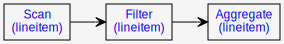

In [15]:
tc.query6()

 
SELECT
	N_NAME,
	SUM(L_EXTENDEDPRICE * (1 - L_DISCOUNT)) AS REVENUE
FROM
	CUSTOMER,
	ORDERS,
	LINEITEM,
	SUPPLIER,
	NATION,
	REGION
WHERE
	C_CUSTKEY = O_CUSTKEY
	AND L_ORDERKEY = O_ORDERKEY
	AND L_SUPPKEY = S_SUPPKEY
	AND C_NATIONKEY = S_NATIONKEY
	AND S_NATIONKEY = N_NATIONKEY
	AND N_REGIONKEY = R_REGIONKEY
	AND R_NAME = 'EUROPE'
	AND O_ORDERDATE >= DATE '1995-01-01'
	AND O_ORDERDATE < DATE '1995-01-01' + INTERVAL '1' YEAR
GROUP BY
	N_NAME
ORDER BY
	REVENUE DESC;

b'RUSSIA' = 3604100.0172999995
b'UNITED KINGDOM' = 3362073.8071999988
b'ROMANIA' = 4014861.1645000014
b'FRANCE' = 3247616.3743
b'GERMANY' = 3758538.1992999995



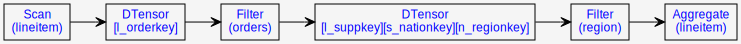

In [16]:
tc.query5()